In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import matplotlib.pyplot 
import Bio
#Neighbour Join Tree
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo
import os
import Bio.Phylo as Phylo

### Step Plot for WHO labels 
```Alpha, Beta, Gamma, Delta and Omicrons are WHO labels```
```The below code is the correct one for creating the combined distance matrix and 
    creating the step plot and NJ tree```

#### USA

In [2]:
# def progressive_fitness(file_path,country):
    
#     # Load the data into a Pandas dataframe
#     df = pd.read_csv(file_path)
# #     print(df)
# #     print(df.columns[0])
# #     print(df.values)

#     # Set the index of the dataframe to the first column
#     df.set_index(df.columns[0], inplace=True)

#     # Create a step plot
#     plt.step(df.index, df.values[0], linewidth=1.5, color='red')


#     # Add labels and title
#     plt.xlabel('Variants',fontsize = 12)
#     plt.ylabel('Fitness Value',fontsize = 12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {country}',fontsize = 12)


#     # Show the plot
#     plt.show()


In [3]:
# progressive_fitness("/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/USA_2021-01_2022-05_dist_mat_who_labels.csv", 'USA')

In [4]:
# progressive_fitness("/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/United Kingdom_2021-01_2022-05_dist_mat_who_labels.csv", 'United Kingdom')

In [5]:
# progressive_fitness("/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/North America_2021-01_2022-05_dist_mat_who_labels.csv", 'North America')

In [6]:
# progressive_fitness("/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/Europe_2021-01_2022-05_dist_mat_who_labels.csv", 'Europe')

## Import the cleaned data

In [7]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
print(df_weekly_sum)

       Variant                   Date                         Location  Freq
0        Alpha  2019-12-30/2020-01-05  Africa / South Africa / Gauteng     1
1        Alpha  2019-12-30/2020-01-05            Asia / India / Kerala     5
2        Alpha  2019-12-30/2020-01-05        Asia / India / Tamil Nadu     1
3        Alpha  2019-12-30/2020-01-05                          Austria     4
4        Alpha  2019-12-30/2020-01-05                  Europe / Cyprus    21
...        ...                    ...                              ...   ...
83732  Omicron  2022-05-30/2022-06-05                      South Korea     3
83733  Omicron  2022-05-30/2022-06-05                            Spain   177
83734  Omicron  2022-05-30/2022-06-05                           Sweden     6
83735  Omicron  2022-05-30/2022-06-05                      Switzerland    69
83736  Omicron  2022-05-30/2022-06-05                              USA  4135

[83737 rows x 4 columns]


## Necessary functions 

In [8]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
# def create_distance_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     distance_matrix = pd.DataFrame(index = clade_list)
#     distance_matrix[clade_list] = np.nan
#     #fill in distance matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 distance_matrix.loc[i,j] = 0
#             else:
#                 distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     return distance_matrix

#this distance matrix only selects clades thats within the clade list
def create_distance_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Variant']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    
    clade_list = sorted(clade_list)
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    distance_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                distance_matrix.loc[i, j] = abs(slope)
                distance_matrix.loc[j, i] = abs(slope)

    return distance_matrix


#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
#     print(f"dataframe after time window:\n {dataframe.head()}")
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [9]:
# import pandas as pd
# import numpy as np

# def create_distance_matrix(df, quarter_continent, variant_choice_set):
#     clade_list = set()
#     for variant in df['Variant']:
#         clades = variant.split(' vs ')
#         clade_list.update(clades)
# #         print(clade_list)

    
#     clade_list = sorted(clade_list)
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
#     distance_matrix.fillna(0, inplace=True)

#     for i in clade_list:
#         for j in clade_list:
#             if i != j:
#                 variant_1 = f"{i} vs {j}"
#                 variant_2 = f"{j} vs {i}"
#                 slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
#                 slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
#                 slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
#                 distance_matrix.loc[i, j] = abs(slope)

#     return distance_matrix


## Create time pairwise distance matrix within a particular time window

In [10]:
# # This function finds the distance matrix among all the clades 

# def automation_mine(country, dataset, start, end, variant_choice_set):
#     '''
#     The automation_mine() dunction takes in a variant_choice_set within 
#     a time window having a start and end date and returns the pairwise distance matrix
#     within that particular time window
#     '''
#     df_weekly = dataset[dataset['Location'] == country]
# #     print(df_weekly.head())

#     #pivot dataframe so that index is date and columns are clades
#     df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
#     df_weekly = df_weekly.reset_index()
    

#     df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

#     #split date column so we can retrieve month and year
#     tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
#     tmp.columns = ['0','1','2','3']

#     #collection date column contains month and year of each week 
#     df_weekly['Collection date'] = tmp['0']
#     cols = df_weekly.columns.tolist()
#     cols = cols[0:1] + cols[-1:] + cols[1:-1]
#     df_weekly = df_weekly[cols]
# #     print(f"df_weekly :\n {df_weekly.head}")
# #     print(f"df_weekly : \n {df_weekly.columns}")
           
#     #specify time frame to analyze
#     df_sum = time_frame(df_weekly, start, end)
#     # df_sum.to_csv(country+"df_sum"+r'.csv')
# #     print(f"df_sum :\n {df_sum}")
#     #calculate log comparisons at each week
#     df_ = clade_comparisons(df_sum)
# #     print(f" df_ : \n{df_}")
#     # df_.to_csv(country+'_clade_comparison')
#     df_['days'] -= df_['days'].iloc[0]
# #     print(f"df_ :\n {df_}")
# #     print(f"df_ :\n {df_.columns}")
    

#     #calculate slopes, have to disregard nans
#     df_slopes = pd.DataFrame()
#     cols = df_.columns.to_list()
#     df_slopes['Variant'] = cols[3:]
# #     print(df_slopes['Variant'])
#     slopes = []
#     for i,v in enumerate(df_.iloc[:,3:]):
#         tmp = df_[~df_.iloc[:,i+3].isnull()]
#         tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
# #         print(tmp)
#         slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
#         #print(len(slopes))
# #         print(df_slopes)
#     df_slopes['Slope'] = slopes
#     # df_slopes.to_csv(country+"_slope_WHO"+r'.csv')
#     df_slopes = pd.DataFrame(df_slopes)
# #     print(df_slopes)
    
# #     dist_mat = create_distance_matrix(df_slopes,'Slope')
# #     # dist_mat.to_csv(country+"_dist_mat_WHO"+r'.csv')
# #     print(f"distance matrix :\n {dist_mat}")

# #     #define the file path
# #     file_path = f'/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/{country + "_" + start + "_" + end + "_dist_mat_who_labels"}.csv'

#     dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
# #     dist_mat.to_csv(file_path, index=True)
#     print(f"Diatance matrix: \n {dist_mat}")
    
#     dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
#     file_name = f"{country}_{start}_{end}_dist_mat.csv"
#     directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     file_path = os.path.join(directory, file_name)
#     dist_mat.to_csv(file_path, index=True)
#     if os.path.isfile(file_path):
#         print(f"Distance matrix saved at: {file_path}")
#     else:
#         print("Error: Failed to save the distance matrix.")


# #     # Specify the directory path
# #     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots/"

# #     # Create the directory if it doesn't exist
# #     if not os.path.exists(directory):
# #         os.makedirs(directory)
    
# #     dif_mat = create_difference_matrix(df_slopes,'Slope')
# #     # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
# #     # print(f"difference matrix :\n {dif_mat}")

# #     #Plot distance matrix as clustermap
# #     sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 1.8)

# #     #create distance array from distance matrix
# #     distance_array = ssd.squareform(dist_mat) 

# #     #create linkage object
# #     distance_linkage = hierarchy.linkage(distance_array)
# #     print(distance_array.shape)
# #     print(dist_mat.shape)

# #     #display clustermap
# #     g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
# #                         cmap = 'coolwarm',vmin=-.023,vmax=0.023, cbar_pos=(0.971, 0.087, .03, 0.7))                     
# #     # g.fig.set_size_inches(10, 10)
# #     # plt.savefig(country+"_clustermap_WHO"+'.jpg', dpi = 300, bbox_inches='tight')
# #     return g

## Code for R^2

In [19]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def automation_mine(country, dataset, start, end, variant_choice_set):
    '''
    The automation_mine() function takes in a variant_choice_set within 
    a time window having a start and end date and returns the pairwise distance matrix
    within that particular time window
    '''
    df_weekly = dataset[dataset['Location'] == country]
    
    # Pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index='Date', columns='Variant', values='Freq')
    df_weekly = df_weekly.reset_index()
    
    df_weekly['Collection date'] = np.random.randint(1, 6, df_weekly.shape[0])
    
    # Split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-', n=3, expand=True)
    tmp.columns = ['0', '1', '2', '3']
    
    # Collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    # Specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
    
    # Calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
    df_['days'] -= df_['days'].iloc[0]
    
    # Calculate slopes, have to disregard nans
    df_slopes = pd.DataFrame()
    cols = df_.columns.to_list()
    df_slopes['Variant'] = cols[3:]
    slopes = []
    r_squared_values = []

    for i, v in enumerate(df_.iloc[:, 3:]):
        tmp = df_[~df_.iloc[:, i+3].isnull()]
        tmp['pseudo_time'] = np.array(range(0, tmp.shape[0])) * 7
        slope, intercept, r_value, p_value, std_err = stats.linregress(tmp.iloc[:, -1], tmp.iloc[:, i+3])
        slopes.append(slope)
        r_squared_values.append(r_value**2)
    
    df_slopes['Slope'] = slopes
    
    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
    print(dist_mat)
    
    file_name = f"{country}_{start}_{end}_dist_mat.csv"
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, file_name)
    dist_mat.to_csv(file_path, index=True)
    if os.path.isfile(file_path):
        print(f"Distance matrix saved at: {file_path}")
    else:
        print("Error: Failed to save the distance matrix.")
    
    for i, variant in enumerate(df_slopes['Variant']):
        print(f"R-squared value for {variant}: {r_squared_values[i]}")


In [20]:
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2021-03', end = '2021-04', variant_choice_set= {'Alpha', 'Beta'})

['2021-03', '2021-04']
          Alpha      Beta
Alpha  0.000000  0.002313
Beta   0.002313  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-03_2021-04_dist_mat.csv
R-squared value for Alpha vs Beta: 0.9766060066559331
R-squared value for Alpha vs Gamma: 0.975965220225772
R-squared value for Alpha vs Delta: 0.9031385851669782
R-squared value for Beta vs Alpha: 0.9766060066559332
R-squared value for Beta vs Gamma: 0.9764693680550017
R-squared value for Beta vs Delta: 0.9212622899488423
R-squared value for Gamma vs Alpha: 0.975965220225772
R-squared value for Gamma vs Beta: 0.9764693680550017
R-squared value for Gamma vs Delta: 0.605654326508271
R-squared value for Delta vs Alpha: 0.9031385851669782
R-squared value for Delta vs Beta: 0.9212622899488423
R-squared value for Delta vs Gamma: 0.6056543265082713


In [21]:
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2021-08', end = '2021-09', variant_choice_set= {'Beta', 'Delta'})

['2021-08', '2021-09']
           Beta     Delta
Beta   0.000000  0.006088
Delta  0.006088  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-08_2021-09_dist_mat.csv
R-squared value for Alpha vs Beta: 0.9703020720807113
R-squared value for Alpha vs Gamma: 0.3197420006096303
R-squared value for Alpha vs Delta: 0.9712256481569674
R-squared value for Beta vs Alpha: 0.9703020720807113
R-squared value for Beta vs Gamma: 0.954706016405293
R-squared value for Beta vs Delta: 0.9448777567827749
R-squared value for Gamma vs Alpha: 0.3197420006096316
R-squared value for Gamma vs Beta: 0.9547060164052932
R-squared value for Gamma vs Delta: 0.9779925200966659
R-squared value for Delta vs Alpha: 0.9712256481569674
R-squared value for Delta vs Beta: 0.9448777567827749
R-squared value for Delta vs Gamma: 0.9779925200966659


In [22]:
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variant_choice_set= {'Delta', 'Omicron'})

['2022-03', '2022-04', '2022-05']
            Delta   Omicron
Delta    0.000000  0.009315
Omicron  0.009315  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2022-03_2022-05_dist_mat.csv
R-squared value for Alpha vs Delta: 0.4335176462323476
R-squared value for Alpha vs Omicron: 0.7472383728770641
R-squared value for Delta vs Alpha: 0.4335176462323476
R-squared value for Delta vs Omicron: 0.9851961431182445
R-squared value for Omicron vs Alpha: 0.7472383728770641
R-squared value for Omicron vs Delta: 0.9851961431182445


In [25]:
# alpha_beta = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2020-12_2021-01_dist_mat.csv', index_col=0)# previous time window
alpha_beta = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-03_2021-04_dist_mat.csv', index_col=0) #updated time window
alpha_beta

,Alpha,Beta
Alpha,0.000000,0.002313
Beta,0.002313,0.000000


In [26]:
beta_delta = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-08_2021-09_dist_mat.csv', index_col= 0)
beta_delta

,Beta,Delta
Beta,0.000000,0.006088
Delta,0.006088,0.000000


In [27]:
delta_omicron = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2022-03_2022-05_dist_mat.csv', index_col=0)
delta_omicron

,Delta,Omicron
Delta,0.000000,0.009315
Omicron,0.009315,0.000000


In [28]:
clade_list = ['Alpha', 'Beta', 'Omicron', 'Delta']
clade_list = sorted(clade_list)
distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
distance_matrix.fillna(0, inplace=True)
print(distance_matrix)

         Alpha  Beta  Delta  Omicron
Alpha        0     0      0        0
Beta         0     0      0        0
Delta        0     0      0        0
Omicron      0     0      0        0


In [29]:
distance_matrix.iloc[0:2, 0:2] = alpha_beta
distance_matrix.iloc[1:3, 1:3] = beta_delta
distance_matrix.iloc[2:4, 2:4] = delta_omicron
distance_matrix
print(type(distance_matrix))

<class 'pandas.core.frame.DataFrame'>


In [19]:
# def plot_progressive_fitness(clade_list, df1, df2, df3, location): #pass dataframe in a sorted order
#     # create an empty dataframe
#     clade_list = sorted(clade_list)
#     distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
#     distance_matrix.fillna(0, inplace=True)
    
#     # assign values to the empty dataframe
#     distance_matrix.iloc[0:2, 0:2] = pd.DataFrame(df1)
#     distance_matrix.iloc[1:3, 1:3] = pd.DataFrame(df2)
#     distance_matrix.iloc[2:4, 2:4] = pd.DataFrame(df3)
#     print(distance_matrix.iloc[0,2])
#     distance_matrix.iloc[0,2] = distance_matrix.iloc[0,1] + distance_matrix.iloc[1,2]
#     print(distance_matrix.iloc[0,2])
#     distance_matrix.iloc[0,3] = distance_matrix.iloc[0,2] + distance_matrix.iloc[3,2]
#     print(distance_matrix.iloc[0,3])
#     distance_matrix.iloc[1,3] = distance_matrix.iloc[1,2] + distance_matrix.iloc[2,3]
#     print(distance_matrix.iloc[1,3])
#     distance_matrix.iloc[2,0] = distance_matrix.iloc[0,2] 
#     distance_matrix.iloc[3,0] = distance_matrix.iloc[0,3] 
#     distance_matrix.iloc[3,1] = distance_matrix.iloc[1,3] 
#     # print the distance matrix
#     print(distance_matrix)
    
#     # Set the index of the dataframe to the first column
#     distance_matrix.set_index(distance_matrix.columns, inplace=True)

#     # Create a step plot
#     plt.step(distance_matrix.index, distance_matrix.values[0], linewidth=1.5, color='red')


#     # Add labels and title
#     plt.xlabel('Variants',fontsize = 12)
#     plt.ylabel('Fitness Value',fontsize = 12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {location}',fontsize = 12)
    

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, country + "_variant_step_plot.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")


#     # Show the plot
#     plt.show()


## Combine the distance matrices and make step plot 

In [30]:
def plot_progressive_fitness(clade_list, df1, df2, df3, location): #pass dataframe in a sorted order
    
    '''
    The plot_progressive_fitness function takes in the individual
    distance matrices and combine them to get a combined distance matrix.
    The distance matrix the used to generate a step plot
    '''
    
    # create an empty dataframe
    clade_list = sorted(clade_list)
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    distance_matrix.fillna(0, inplace=True)
    
    # assign values to the empty dataframe
    distance_matrix.iloc[0:2, 0:2] = pd.DataFrame(df1)
    distance_matrix.iloc[1:3, 1:3] = pd.DataFrame(df2)
    distance_matrix.iloc[2:4, 2:4] = pd.DataFrame(df3)
    
    distance_matrix.iloc[0,2] = distance_matrix.iloc[0,1] + distance_matrix.iloc[1,2]
    distance_matrix.iloc[0,3] = distance_matrix.iloc[0,2] + distance_matrix.iloc[3,2]
    distance_matrix.iloc[1,3] = distance_matrix.iloc[1,2] + distance_matrix.iloc[2,3]
    distance_matrix.iloc[2,0] = distance_matrix.iloc[0,2] 
    distance_matrix.iloc[3,0] = distance_matrix.iloc[0,3] 
    distance_matrix.iloc[3,1] = distance_matrix.iloc[1,3] 
    
    print(f"Distance Matrix :\n {distance_matrix}")
    
    # Set the index of the dataframe to the first column
    distance_matrix.set_index(distance_matrix.columns, inplace=True)

    
    #export the combined distance matrix
    #export the distance matrix
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_combined_distance_matrix_for_who_labels.csv")
    distance_matrix.to_csv(filename, index=False)
    
    
    # Create a step plot
    plt.figure(figsize=(3, 3))  # Set figure size to 3 by 3
    plt.step(distance_matrix.index, distance_matrix.values[0], linewidth=1.5, color='red')

    
    # Add labels and title
#     plt.xlabel('Variants', fontsize=12)
    plt.ylabel('Fitness Value', fontsize=12)
    plt.title(f'Fitness Stair\n Location: {location}', fontsize=11)

    # Set the background color to white
    plt.gca().set_facecolor('white')

    
    # Add axis lines
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(-0.1, color='black', linewidth=0.5)
    
    
    # Rotate x-axis labels
#     plt.xticks(range(len(distance_matrix.index)), distance_matrix.index, rotation=90, fontsize=8)  # Adjust fontsize as needed
    
    # Add custom x-axis labels for time windows
    # x_ticks_positions = [0.5, 1.5, 2.5]
    # x_ticks_labels = ['Dec 2020 - Jan 2021', 'Aug 2021 - Sep 2021', 'Mar 2022 - May 2022']
    # plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90, fontsize=7)
    
    plt.xticks([])  # Remove x-axis tick labels
    plt.yticks()

    
    # Display the labels on the graph
    categories = ['alpha', 'beta', 'delta', 'omicron']
    x = range(len(categories))
    values = distance_matrix.values[0][0:5]
    print(values)
    for i in range(len(categories)):
        plt.text(x[i]+0.01, values[i], f'{categories[i]}', ha='left', va='bottom')

#     # Rotate x-axis labels
#     plt.xticks(rotation=90)
#     plt.yticks()


    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_variant_step_plot.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    
    # Show the plot
    plt.show()


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.002313  0.008400  0.017715
Beta     0.002313  0.000000  0.006088  0.015403
Delta    0.008400  0.006088  0.000000  0.009315
Omicron  0.017715  0.015403  0.009315  0.000000
[0.         0.0023125  0.00840042 0.01771521]


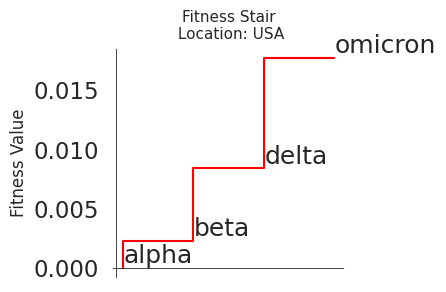

""


In [31]:
combined_distance_matrix = pd.DataFrame(plot_progressive_fitness(['Alpha', 'Beta', 'Omicron', 'Delta'], alpha_beta, beta_delta, delta_omicron, 'USA'))
combined_distance_matrix

#### Load the combined distance matrix  for USA
This distance matrix has been created by using the transitive property of inequality 
(a>b, b>c then a>c)


In [32]:
distance_matrix = pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv")
distance_matrix

,Alpha,Beta,Delta,Omicron
0,0.000000,0.002313,0.008400,0.017715
1,0.002313,0.000000,0.006088,0.015403
2,0.008400,0.006088,0.000000,0.009315
3,0.017715,0.015403,0.009315,0.000000


In [33]:
def create_difference_matrix(distance_matrix):
    difference_matrix = distance_matrix.copy()

    # Iterate over the rows and columns of the difference_matrix
    for i, row in difference_matrix.iterrows():
        for j in difference_matrix.columns:
            if i != j:
                # Check if the row_vs_col value is negative
                if distance_matrix.loc[i, j] < 0:
                    # Set values above the main diagonal to the negative value
                    difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = abs(difference_matrix.loc[i, j])
                else:
                    # Set values below the main diagonal to the positive value
                    difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = -abs(difference_matrix.loc[i, j])

    return difference_matrix

distance_matrix.set_index(distance_matrix.columns, inplace=True)
print(distance_matrix)
dif_mat = create_difference_matrix(distance_matrix)
    # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
    # filename1 = os.path.join(directory, location + "_continent_combined_diference_matrix_for_who_labels.csv")
    # print(f"Combined difference matrix saved at : {filename1}")
    # dif_mat.to_csv(filename1, index=False)
    
print(f"Difference matrix :\n {dif_mat}")

            Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.002313  0.008400  0.017715
Beta     0.002313  0.000000  0.006088  0.015403
Delta    0.008400  0.006088  0.000000  0.009315
Omicron  0.017715  0.015403  0.009315  0.000000
Difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.002313 -0.008400 -0.017715
Beta     0.002313  0.000000 -0.006088 -0.015403
Delta    0.008400  0.006088  0.000000 -0.009315
Omicron  0.017715  0.015403  0.009315  0.000000


### Plot the heatmap 

/tmp/ipykernel_2779562/933526109.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(cax.get_yticklabels(), fontsize=7)


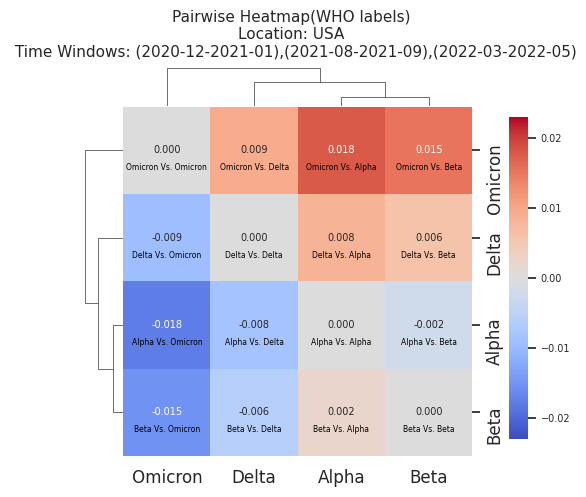

In [34]:
import warnings
#Plot distance matrix as clustermap
sns.set(rc={'figure.figsize': (2, 2)}, font_scale=1.1)  # Adjust the figsize as per your preference

#create distance array from distance matrix
distance_array = ssd.squareform(distance_matrix) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)
#print(distance_array.shape)
#print(dist_mat.shape)

# # Display clustermap (no annotation)
# g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
#                cmap='coolwarm', vmin=-.023, vmax=0.023, cbar_pos=(0.971, 0.274, .05, 0.54 ),figsize=(5, 5))
 

# Display clustermap with annotations
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
                        cmap='coolwarm', vmin=-0.023, vmax=0.023, cbar_pos=(0.969, 0.147, 0.04, 0.7),
                        annot=True, fmt='.3f', annot_kws={"size": 7}, figsize=(4.6, 4.6), dendrogram_ratio=0.102)
    
# Adjust colorbar label size
cax = g.cax
cax.set_yticklabels(cax.get_yticklabels(), fontsize=7)


#***************************************************************************************************************************************
#Put the labels compared in each cell as text
# Get the x-axis and y-axis labels from the clustermap plot
x_labels = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
y_labels = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
# Add annotated texts in the cells
for i in range(dif_mat.shape[0]):
    for j in range(dif_mat.shape[1]):
        text = f"{x_labels[i]} Vs. {y_labels[j]}"
        # value = f"{dif_mat.iloc[i, j]:.3f}"
        text_x = g.ax_heatmap.get_xticks()[j]
        text_y = g.ax_heatmap.get_yticks()[i]
        g.ax_heatmap.text(text_x, text_y + 0.2, text, ha='center', va='center', fontsize=5.5, color='black')
            
#***************************************************************************************************************************************
g.fig.suptitle(f'Pairwise Heatmap(WHO labels) \nLocation: USA \n Time Windows: (2020-12-2021-01),(2021-08-2021-09),(2022-03-2022-05)', fontsize = 11, y = 1.08)

# Specify the directory path
directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the figure to the specified directory with DPI set to 300
filename = os.path.join(directory, "USA_distance_mat_heatmap.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [26]:
# #infer the other values by summing up the fitness value
# combined_distance_matrix.iloc[2, 2]
# print(type(combined_distance_matrix))

## Create NJ tree
``` using the combined distance matrix ```

In [35]:
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo

# Set the plot style
plt.style.use('ggplot')  # Replace 'seaborn' with your desired style

def create_nj_tree(filepath, location):
    # Read the distance matrix from the CSV file
    df = pd.read_csv(filepath)
    
    

    # Set the index of the dataframe to the first column
    df.set_index(df.columns, inplace=True)
    print(df)
    # Create a list of row names as strings
    names = df.index.astype(str).tolist()
    
    

    # Generate the lower triangle distance matrix
    distance_matrix = []
    for i in range(len(df)):
        row = []
        for j in range(i+1):
            row.append(round(df.iloc[i][j], 9))
        distance_matrix.append(row)
        
        

    # Create a DistanceMatrix object
    dm = DistanceMatrix(names, distance_matrix)
    print(dm)
    # Construct the tree
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)
    tree.ladderize()
    
    

    # Add branch lengths to the tree
    for clade in tree.find_clades():
        if clade.branch_length is None:
            clade.branch_length = 0.0
        clade.branch_length = round(clade.branch_length, 6)

    # Draw the tree with labels
    fig = plt.figure(figsize=(5, 4), dpi=500)
    axes = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)
    
    
    # Adjust label placement
    plt.tight_layout()
    plt.show()
    
    

    # Save the figure to a file
    directory = "/scr/mjpantho/Pantho_differential_fitness/nj_tree_plots"

    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_nj_tree.png")
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    
    #save the newick file to get the absolute distance
    # specify the directory to save the file
    dir_path = '/scr/mjpantho/Pantho_differential_fitness/Newick files'

    # specify a unique name for the file
    file_name_ = location + '.nwk'

    # create the full file path
    file_path = os.path.join(dir_path, file_name_)

    # Write the tree to file
    Phylo.write(tree, file_path, format="newick")

    plt.close(fig)


## USA combined

            Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.002313  0.008400  0.017715
Beta     0.002313  0.000000  0.006088  0.015403
Delta    0.008400  0.006088  0.000000  0.009315
Omicron  0.017715  0.015403  0.009315  0.000000
Alpha	0
Beta	0.0023125	0
Delta	0.008400424	0.006087924	0
Omicron	0.017715214	0.015402714	0.00931479	0
	Alpha	Beta	Delta	Omicron


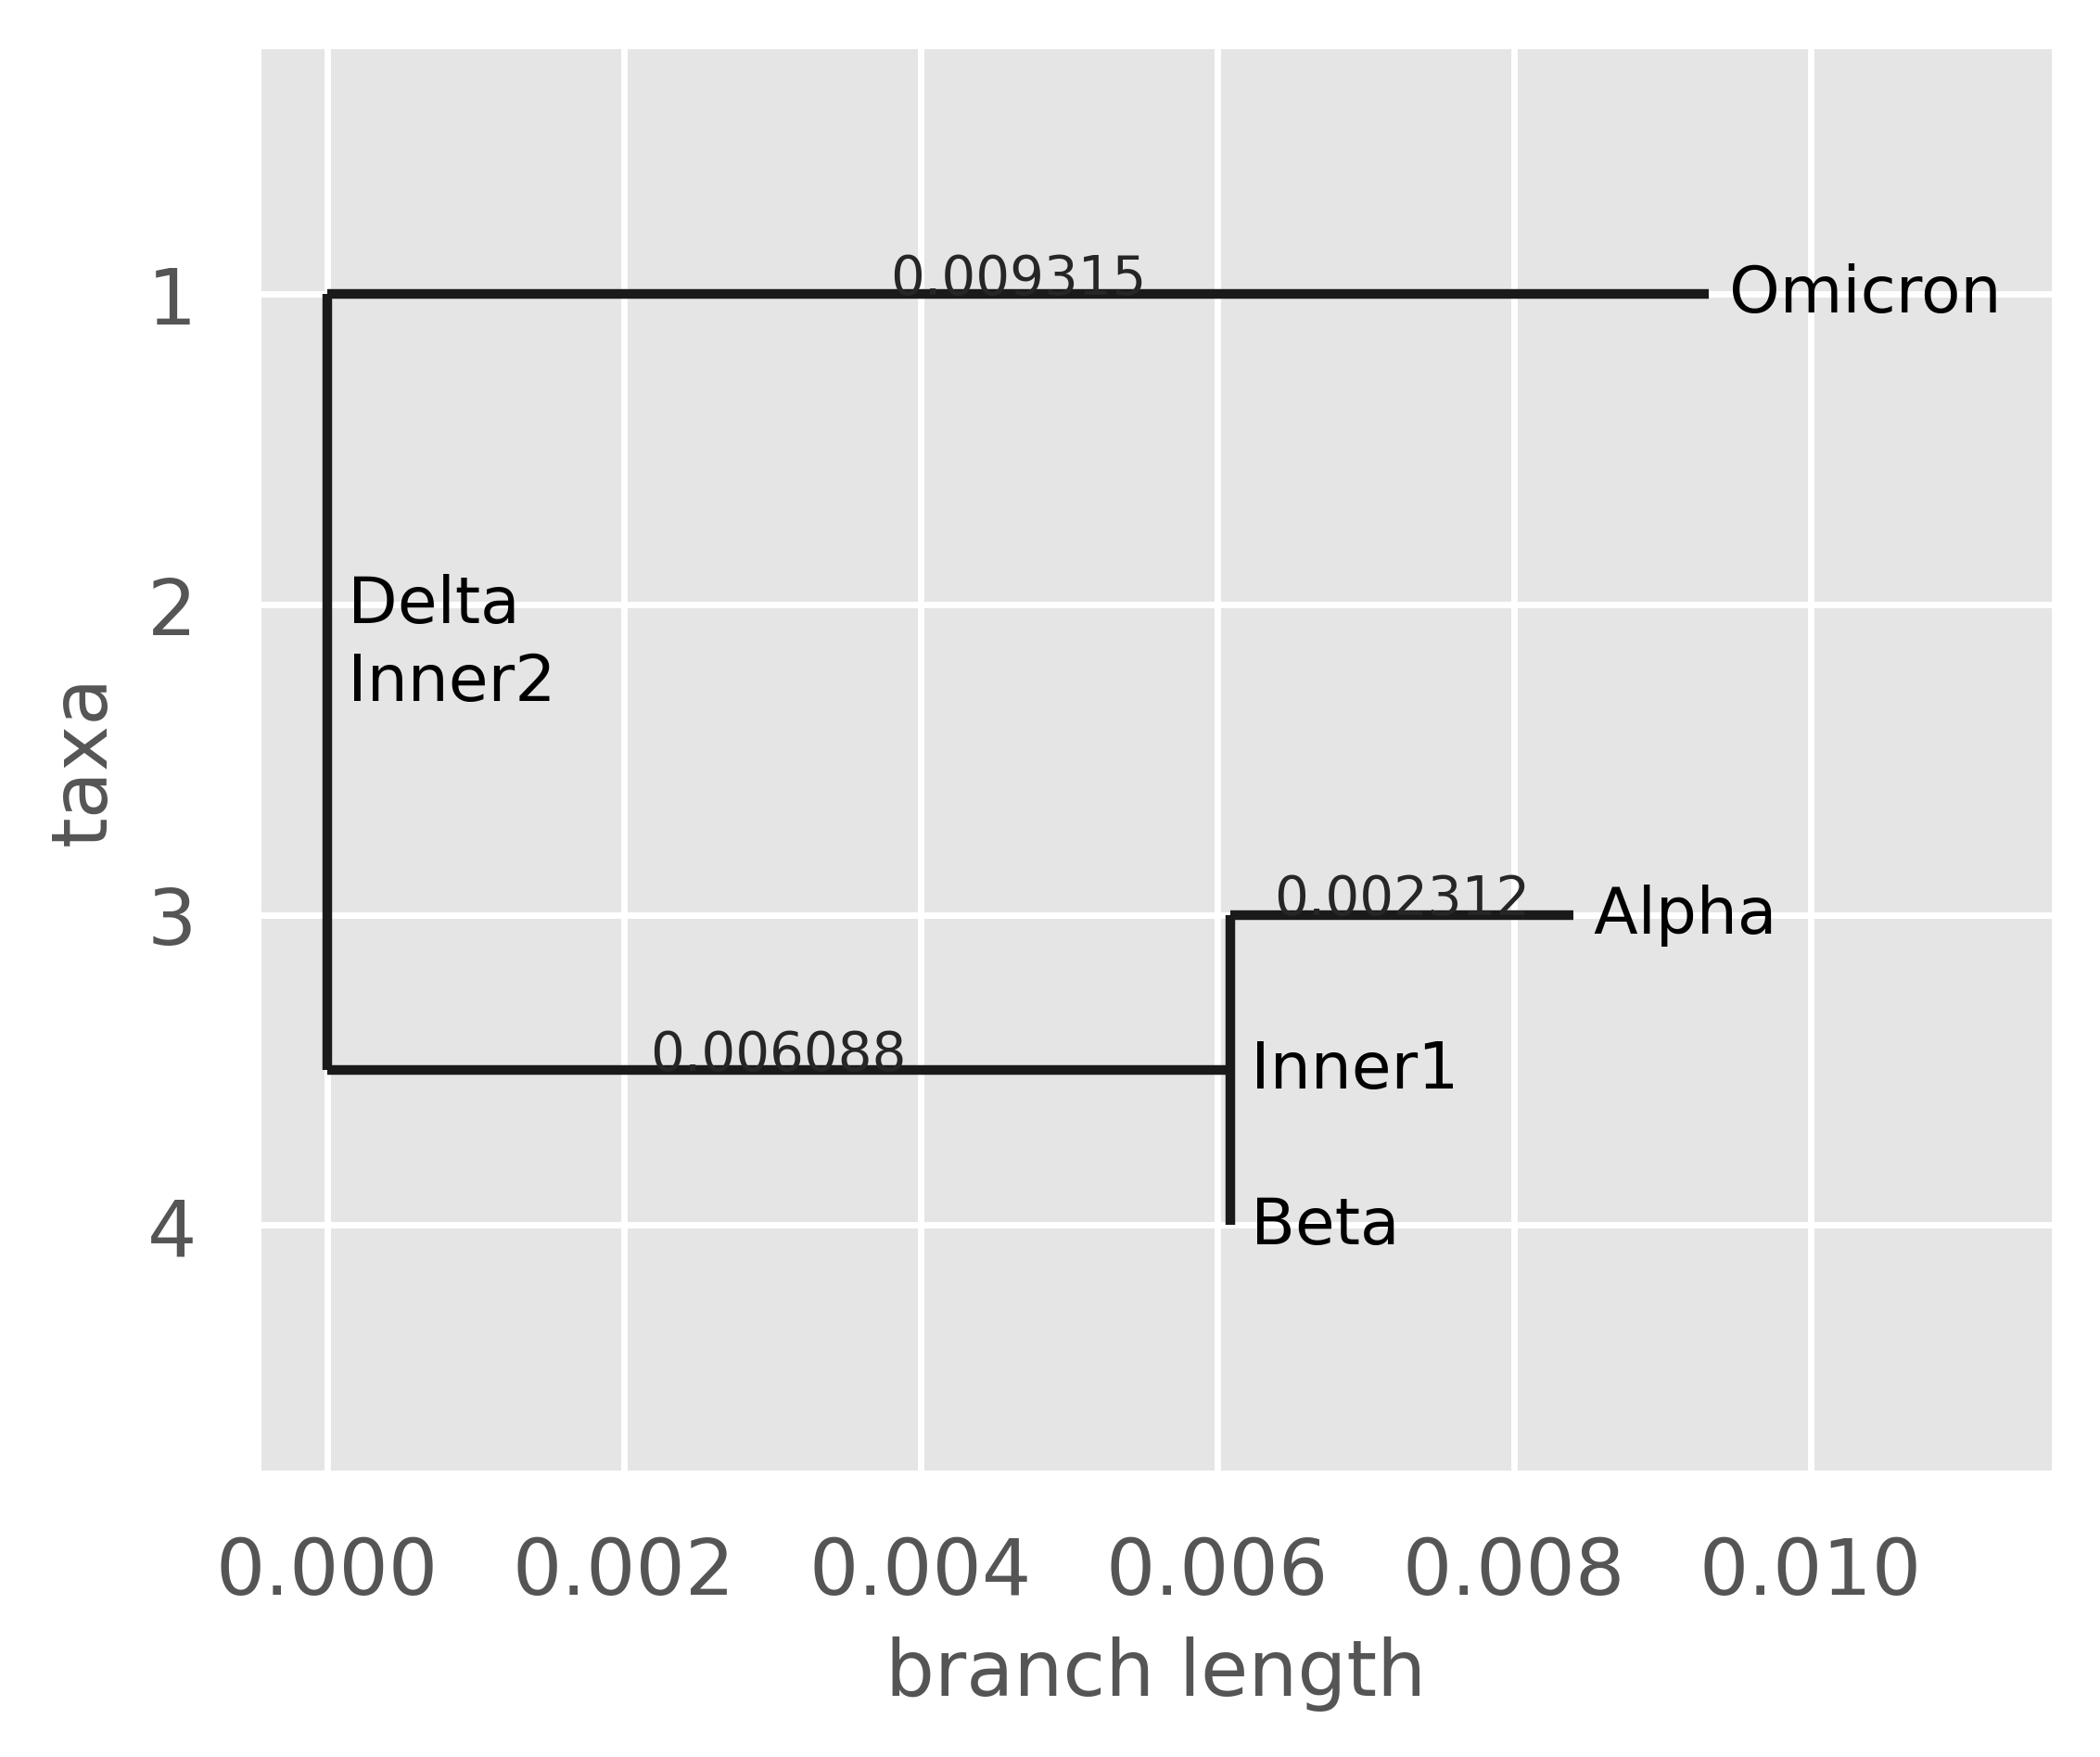

<Figure size 200x200 with 0 Axes>

In [36]:
create_nj_tree("/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv", 'USA')

### Create the Trianguar heatmap

In [40]:
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo

from io import StringIO

# Function for creating the heatmap

def create_triangular_heatmap(filepath, location):
    # Read the distance matrix from the CSV file
    # df = pd.read_csv(filepath)
    
    # import file with data
    data = pd.read_csv(filepath)
    print(data)
    # Set the index of the dataframe to the first column
    data.set_index(data.columns, inplace=True)
    print(data)
 
    # creating mask
    mask = np.triu(np.ones_like(data))
 
    plt.figure(figsize=(3.5, 3.5), facecolor='white')  # Set the figure size here
    # plotting a triangle correlation heatmap
    sns.heatmap(data, cmap="coolwarm", mask=mask,
                        annot=True, fmt='.3f')
    
    # Add title to the heatmap
    plt.title(f'Lower Traingular Heatmap \nLocation: {location}', fontsize = 11, y = 1.05)

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, f"{location}triaangle__distance_mat_heatmap.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight", transparent = "True")
    
    # displaying heatmap
    plt.show()

#     # Set the index of the dataframe to the first column
#     df.set_index(df.columns, inplace=True)
#     print(df)
#     # Create a list of row names as strings
#     names = df.index.astype(str).tolist()
    
    

#     # Generate the lower triangle distance matrix
#     distance_matrix = []
#     for i in range(len(df)):
#         row = []
#         for j in range(i+1):
#             row.append(round(df.iloc[i][j], 9))
#         distance_matrix.append(row)
#     print(distance_matrix)
#     # Create a DistanceMatrix object
#     dm = DistanceMatrix(names, distance_matrix)
#     print(dm)

    
#     # Create a mask for the upper triangle
#     mask = pd.DataFrame(np.triu(np.ones(dm.shape), k=1), index=dm.index, columns=dm.columns)

#     # Plot the heatmap
#     sns.heatmap(dm, annot=True, fmt=".5f", cmap="YlGnBu", mask=mask)

#     # Show the plot
#     plt.show()



      Alpha      Beta     Delta   Omicron
0  0.000000  0.002825  0.008913  0.018228
1  0.002825  0.000000  0.006088  0.015403
2  0.008913  0.006088  0.000000  0.009315
3  0.018228  0.015403  0.009315  0.000000
            Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.002825  0.008913  0.018228
Beta     0.002825  0.000000  0.006088  0.015403
Delta    0.008913  0.006088  0.000000  0.009315
Omicron  0.018228  0.015403  0.009315  0.000000


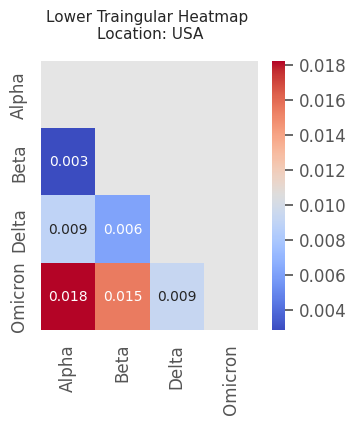

In [41]:
create_triangular_heatmap("/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv", 'USA')

### Nj tree for Europe

            Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.012519  0.044362  0.117089
Beta     0.012519  0.000000  0.031843  0.104570
Delta    0.044362  0.031843  0.000000  0.072727
Omicron  0.117089  0.104570  0.072727  0.000000
Alpha	0
Beta	0.012518749	0
Delta	0.044361982	0.031843233	0
Omicron	0.117089051	0.104570302	0.072727069	0
	Alpha	Beta	Delta	Omicron


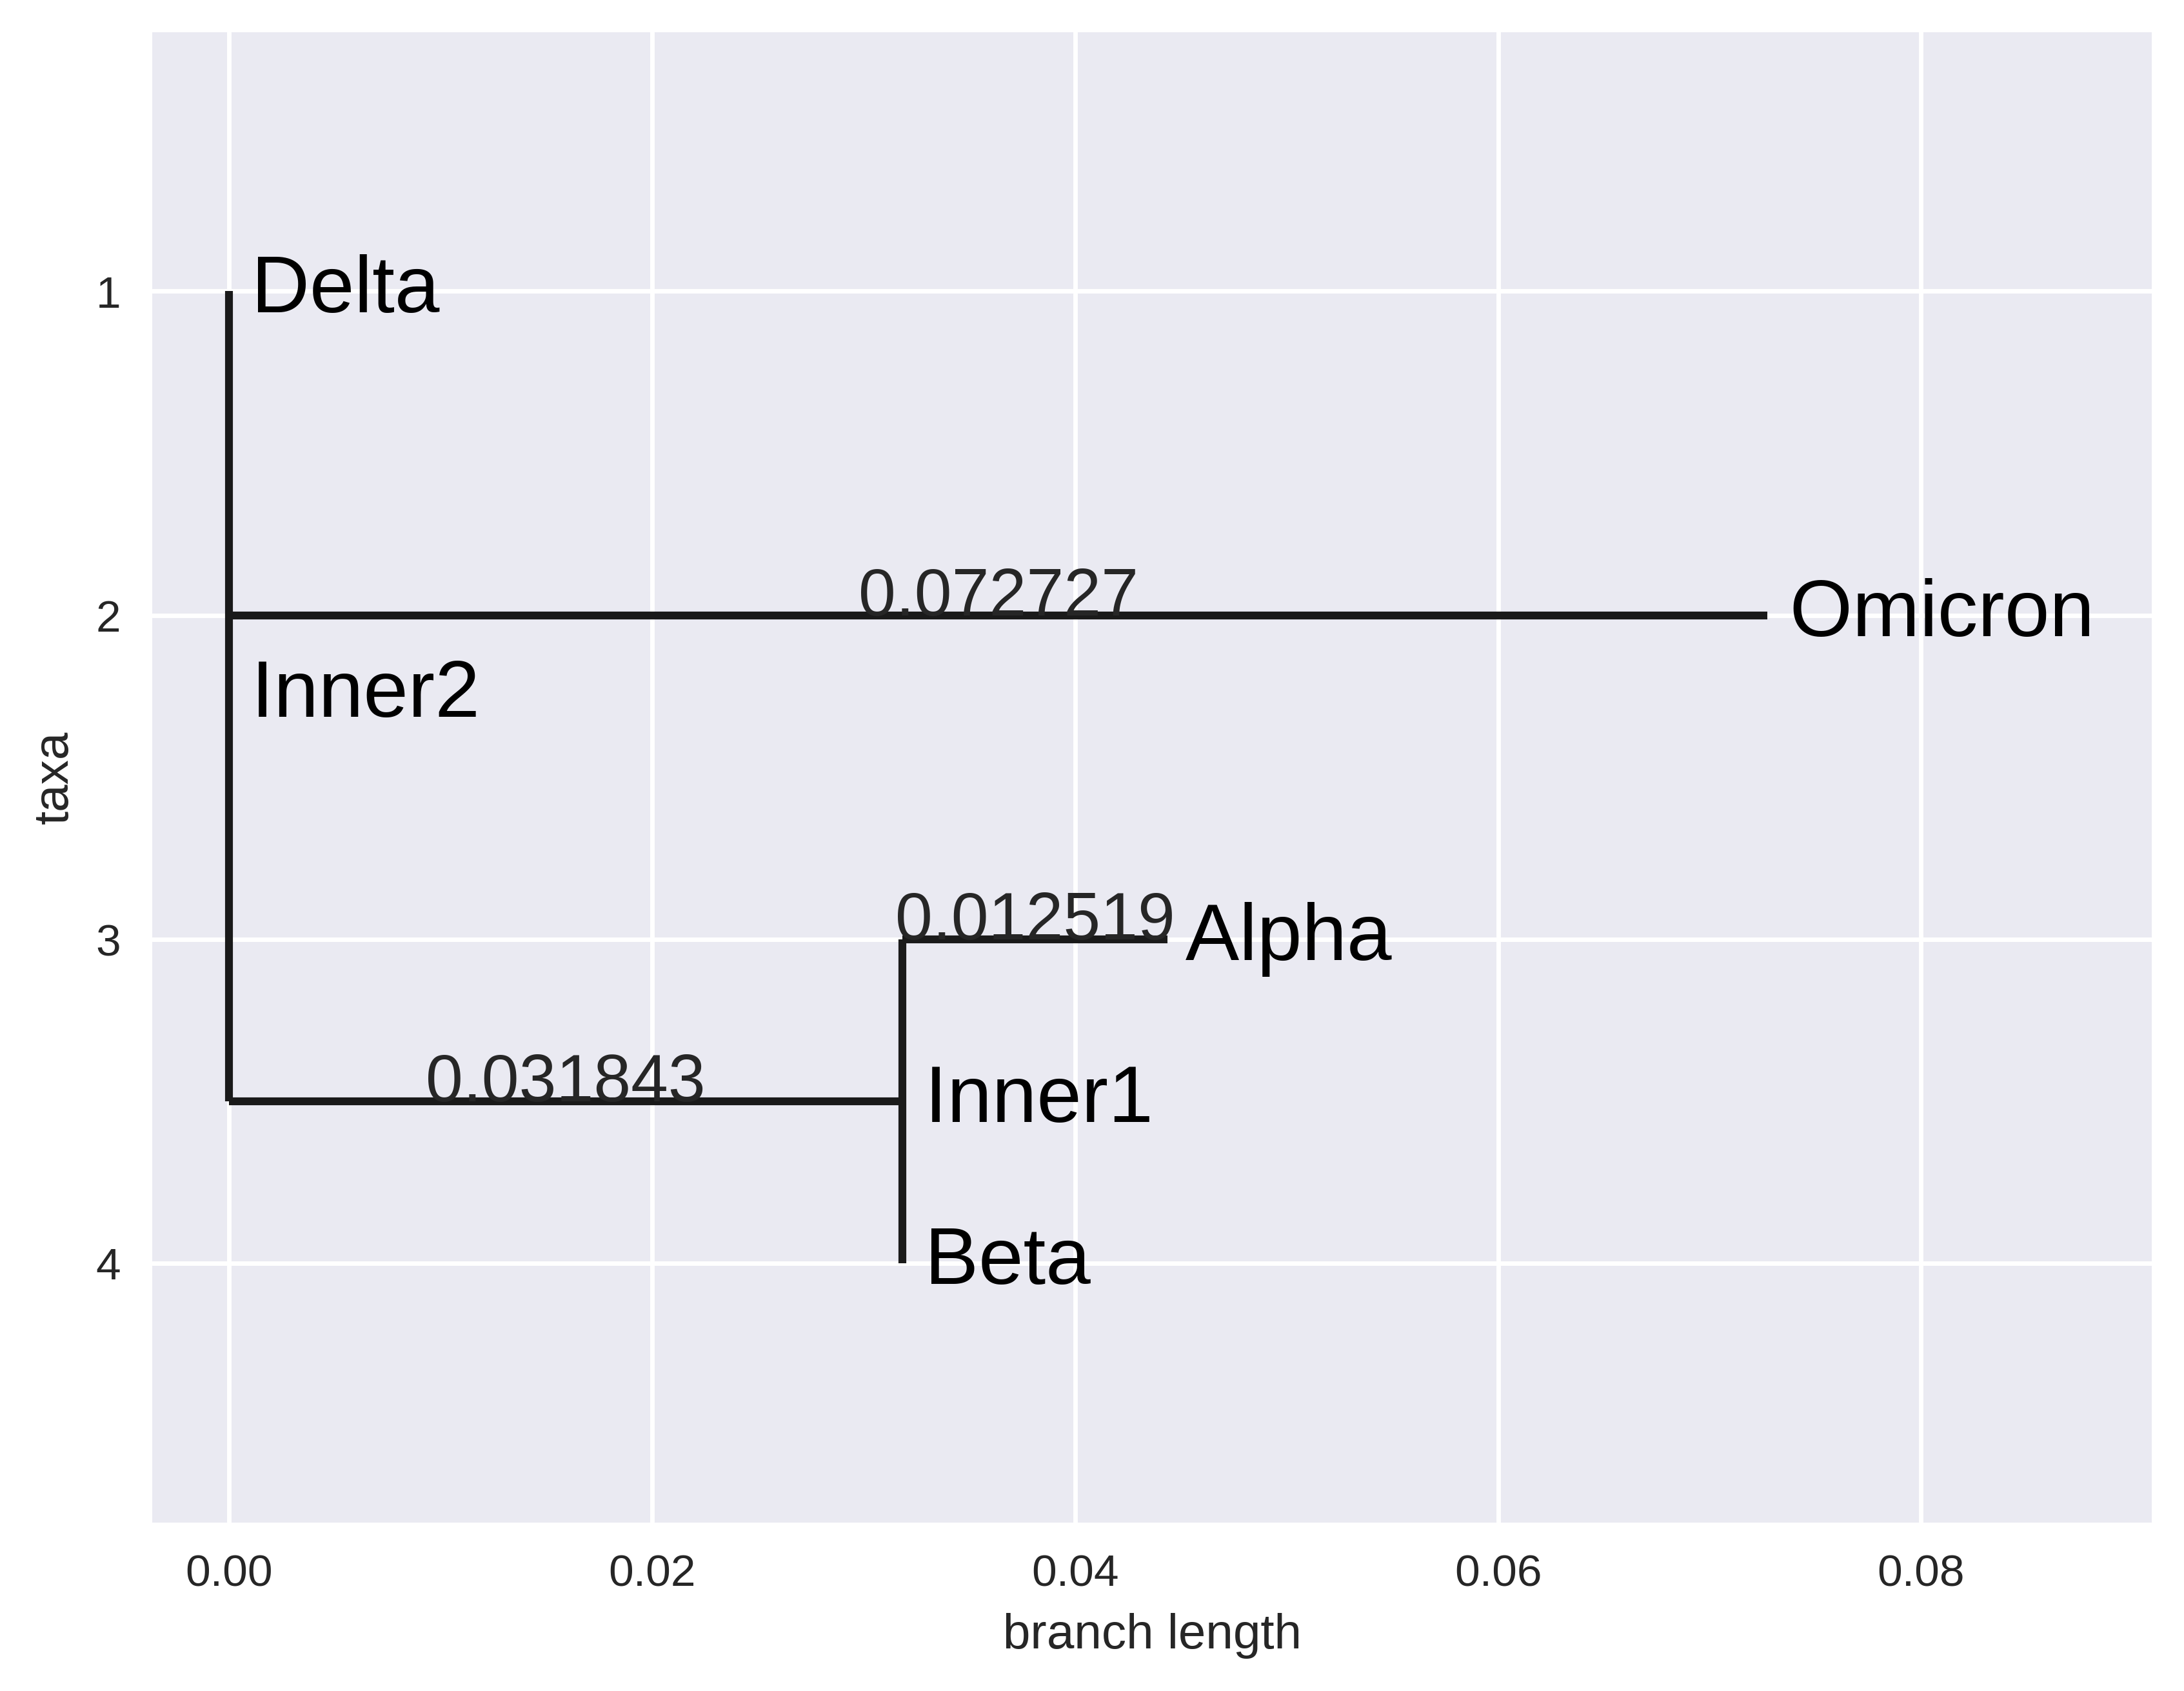

<Figure size 800x550 with 0 Axes>

In [25]:
create_nj_tree("/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_continent_combined_distance_matrix_for_who_labels.csv", 'Europe')

# *END*

In [ ]:
Europe_continent_combined_distance_matrix_for_who_labels

## Plotly 3d plots

In [11]:
# import plotly.graph_objects as go
# import pandas as pd

# # Read data from a csv
# z_data = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv')
# z_data.set_index(z_data.columns, inplace=True)

# # Get the x, y coordinates
# x_coords = z_data.columns
# y_coords = z_data.index

# # Create the surface plot
# surface = go.Surface(
#     x=x_coords,
#     y=y_coords,
#     z=z_data.values,
#     text=z_data.values.round(2),  # Assign the z-values as labels
#     hoverinfo='text',
#     colorscale='Jet'
# )

# # Create the figure
# fig = go.Figure(data=[surface])

# # Update the layout
# fig.update_layout(
#     title='Surface Plot with Variant Labels',
#     autosize=False,
#     width=800,
#     height=600,
#     scene=dict(
#         xaxis_title='X Axis',
#         yaxis_title='Y Axis',
#         zaxis_title='Z Axis'
#     )
# )

# # Show the plot
# fig.show()


In [3]:
# import plotly.graph_objects as go
# import pandas as pd

# # Read data from a csv
# z_data = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv')
# z_data.set_index(z_data.columns, inplace=True)

# # Get the x, y coordinates
# x_coords = z_data.columns
# y_coords = z_data.index

# # Create a meshgrid of x, y coordinates
# X, Y = pd.np.meshgrid(x_coords, y_coords)

# # Create labels for each point based on compared variants
# labels = []
# for i in range(len(y_coords)):
#     for j in range(len(x_coords)):
#         label = f"{y_coords[i]} vs {x_coords[j]}"
#         z_value = z_data.values[i, j]
#         text = f"{label}<br>Fitness Value: {z_value}"
#         labels.append(text)

# # Create the scatter3d trace
# scatter = go.Scatter3d(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=z_data.values.flatten(),
#     text=labels,
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=z_data.values.flatten(),
#         colorscale='Jet',
#         opacity=0.8
#     ),
#     hoverinfo='text'
# )

# # Create the surface trace
# surface = go.Surface(
#     x=x_coords,
#     y=y_coords,
#     z=z_data.values,
#     hoverinfo='text',  # Enable hover info for the surface
#     showscale=True,  # Disable the color scale for the surface,
#     colorscale = 'Rainbow'
#     # showlegend = True
# )

# # Create the layout
# layout = go.Layout(
#     title='Pairwise Fitness Landscape of the SARS-CoV-2 Variants (WHO labels)',
#     scene=dict(
#         xaxis=dict(title='X Axis'),
#         yaxis=dict(title='Y Axis'),
#         zaxis=dict(title='Z Axis')
#     ),
#     width=1000,  # Set the width of the plot
#     height=800  # Set the height of the plot
# )

# # Create the figure
# fig = go.Figure(data=[surface, scatter], layout=layout)

# # Show the plot
# fig.show()


In [4]:
# import plotly.graph_objects as go
# import pandas as pd

# # Read data from a csv
# z_data = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv')
# z_data.set_index(z_data.columns, inplace=True)
# print(z_data)

# # Get the x, y coordinates
# x_coords = z_data.columns
# y_coords = z_data.index

# # Create a meshgrid of x, y coordinates
# X, Y = pd.np.meshgrid(x_coords, y_coords)

# # Create labels for each point based on compared variants
# labels = []
# for i in range(len(y_coords)):
#     for j in range(len(x_coords)):
#         label = f"{y_coords[i]} vs {x_coords[j]}"
#         z_value = z_data.values[i, j]
#         text = f"{label}<br>Fitness Value: {z_value:.4f}"  # Format z value to 4 decimal points
#         labels.append(text)

# # Create the scatter3d trace
# scatter = go.Scatter3d(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=z_data.values.flatten(),
#     text=labels,
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=z_data.values.flatten(),
#         colorscale='jet',
#         opacity= 1
#     ),
#     hoverinfo='text'
# )

# # Create the surface trace
# surface = go.Surface(
#     x=x_coords,
#     y=y_coords,
#     z=z_data.values,
#     hoverinfo='text',  # Enable hover info for the surface
#     showscale=True,  # Disable the color scale for the surface,
#     colorscale='Rainbow',
#     opacity= 0.55,
#     colorbar=dict(len=0.62)  # Adjust the length of the color scale
#     # showlegend=True
# )

# # Create the layout
# layout = go.Layout(
#     title='Pairwise Fitness Landscape of the SARS-CoV-2 Variants (WHO labels)',
#     scene=dict(
#         xaxis=dict(title='X Axis'),
#         yaxis=dict(title='Y Axis'),
#         zaxis=dict(title='Fitness Values'),
#         aspectratio=dict(x=1.2, y=1.2, z= 0.5)
#     ),
#     width=1000,  # Set the width of the plot
#     height=800,  # Set the height of the plot
#     # margin=dict(l=5, r=5, t=5, b=5)  # Adjust the margins
# )

# # Create the figure
# fig = go.Figure(data=[surface, scatter], layout=layout)

# # Show the plot
# fig.show()


In [5]:
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt

# # Read data from a csv
# z_data = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv')
# z_data.set_index(z_data.columns, inplace=True)

# # Convert the values in z_data to numeric type
# z_data = z_data.astype(float)

# # Get the x, y coordinates
# x_coords = np.arange(len(z_data.columns))
# y_coords = np.arange(len(z_data.index))

# #get the x and y axis labels
# x_coords_labels = z_data.columns
# y_coords_labels = z_data.index


# # Create a meshgrid of x, y coordinates
# x, y = np.meshgrid(x_coords, y_coords)
# z = z_data.values

# fig = plt.figure(figsize=(14, 9))
# ax = plt.axes(projection='3d')

# my_cmap = plt.get_cmap('cool')

# surf = ax.plot_surface(x, y, z, cmap=my_cmap, edgecolor='none')

# # Create labels for each point based on compared variants
# labels = []
# for i in range(len(y_coords)):
#     for j in range(len(x_coords)):
#         label = f"{y_coords_labels[i]} vs {x_coords_labels[j]}"
#         z_value = z_data.values[i, j]
#         text = f"{label}\nFitness Value: {z_value:.3f}"
#         labels.append(text)
#         ax.text(x_coords[j], y_coords[i], z_value, text, fontsize=6.5, color='black', ha='center', va='center')

# fig.colorbar(surf, ax=ax, shrink=0.7, aspect=7)

# ax.set_title('Surface plot')

# plt.show()


In [6]:
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt

# def landscape(file_path, elevation, azimuth):
#     # Read data from a csv
#     z_data = pd.read_csv(file_path)
#     z_data.set_index(z_data.columns, inplace=True)
#     print(z_data)

#     # Convert the values in z_data to numeric type
#     z_data = z_data.astype(float)

#     # Get the x, y coordinates
#     x_coords = np.arange(len(z_data.columns))
#     y_coords = np.arange(len(z_data.index))

#     #get the x and y axis labels
#     x_coords_labels = z_data.columns
#     y_coords_labels = z_data.index


#     # Create a meshgrid of x, y coordinates
#     x, y = np.meshgrid(x_coords, y_coords)
#     z = z_data.values

#     fig = plt.figure(figsize=(14, 9))
#     ax = plt.axes(projection='3d')

#     my_cmap = plt.get_cmap('rainbow')

#     surf = ax.plot_surface(x, y, z, cmap=my_cmap, edgecolor='none')

#     # Create labels for each point based on compared variants
#     labels = []
#     for i in range(len(y_coords)):
#         for j in range(len(x_coords)):
#             label = f"{y_coords_labels[i]} vs {x_coords_labels[j]}"
#             z_value = z_data.values[i, j]
#             text = f"{label}\nFitness Value: {z_value:.3f}"
#             labels.append(text)
#             ax.text(x_coords[j], y_coords[i], z_value, text, fontsize= 5.5, color='black', ha='center', va='center')

#     fig.colorbar(surf, ax=ax, shrink=0.5, aspect=7)

#     ax.set_title('Pairwise Fitness Landscape of SARS-CoV-2 Variants(WHO label)')

#     # Rotate the plot
#     ax.view_init(elev = elevation, azim = azimuth)  # Set the elevation and azimuth angles


#     plt.show()


In [7]:
# landscape('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv',
#           elevation=50,
#           azimuth=50)

In [10]:
# import plotly.graph_objects as go
# import pandas as pd

# # Read data from a csv
# z_data = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv')
# z_data.set_index(z_data.columns, inplace=True)

# # Get the x, y coordinates
# x_coords = z_data.columns
# y_coords = z_data.index

# # Create a meshgrid of x, y coordinates
# X, Y = pd.np.meshgrid(x_coords, y_coords)

# # Create labels for each point based on compared variants
# labels = []
# for i in range(len(y_coords)):
#     for j in range(len(x_coords)):
#         label = f"{y_coords[i]} vs {x_coords[j]}"
#         z_value = z_data.values[i, j]
#         text = f"{label}<br>Z: {z_value}"
#         labels.append(text)

# # Create the scatter3d trace
# scatter = go.Scatter3d(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=z_data.values.flatten(),
#     text=labels,
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=z_data.values.flatten(),
#         colorscale='Jet',
#         opacity=0.8
#     ),
#     hoverinfo='text'
# )

# # Create the surface trace
# surface = go.Surface(
#     x=x_coords,
#     y=y_coords,
#     z=z_data.values,
#     showscale=False  # Disable the color scale for the surface
# )

# # Create the layout
# layout = go.Layout(
#     title='Surface Plot with Variant Labels',
#     scene=dict(
#         xaxis=dict(title='X Axis'),
#         yaxis=dict(title='Y Axis'),
#         zaxis=dict(title='Z Axis')
#     ),
#     width=1000,  # Set the width of the plot
#     height=800  # Set the height of the plot
# )

# # Create the figure
# fig = go.Figure(data=[surface, scatter], layout=layout)

# # Show the plot
# fig.show()


In [1]:
# fitness_values = np.array([[0, 0.002825, 0.011185, 0.06964],
#                           [0.002825, 0, 0.00836, 0.066815],
#                           [0.0011185, 0.00836, 0, 0.058455],
#                           [0.06964, 0.066815, 0.058455, 0]])

# row_labels = ['Alpha', 'Beta', 'Delta', 'Omicron']
# column_labels = ['Alpha', 'Beta', 'Delta', 'Omicron']

# df = pd.DataFrame(fitness_values, index=row_labels, columns=column_labels)
# # df.index.name = 'Variant'

# print(df)

In [2]:
# def progressive_fitness(dataFrame, country):
    
#     # Load the data into a Pandas dataframe
# #     df = pd.read_csv(file_path)
# #     print(df)
# #     print(df.columns[0])
# #     print(df.values)

#     # Set the index of the dataframe to the first column
#     dataFrame.set_index(df.columns, inplace=True)

#     # Create a step plot
#     plt.step(dataFrame.index, dataFrame.values[0], linewidth=1.5, color='red')


#     # Add labels and title
#     plt.xlabel('Variants',fontsize = 12)
#     plt.ylabel('Fitness Value',fontsize = 12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {country}',fontsize = 12)


#     # Show the plot
#     plt.show()

In [3]:
# progressive_fitness(df, "USA")

#### USA

In [69]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the data into a Pandas dataframe
# df = pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/United Kingdom_2021-01_2022-05_dist_mat_who_labels.csv")
# print(df)
# print(df.columns[0])
# print(df.values)

# # Set the index of the dataframe to the first column
# df.set_index(df.columns[0], inplace=True)

# # Create a step plot
# plt.step(df.index, df.values[0], linewidth=1.5, color='red')


# # Add labels and title
# plt.xlabel('Variants')
# plt.ylabel('Fitness Value')
# plt.title('Progressive fitness of Covid Variants for UK',fontsize = 12)


# # Show the plot
# plt.show()


In [42]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the data into a Pandas dataframe
# df = pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv")
# # df.set_index(df.columns[0], inplace=True)
# print(df)

# # Create a step plot
# plt.figure(figsize=(5, 5))  # Set figure size to 3 by 3
# plt.step(df.index, df.values[0], linewidth=1.5, color='red')


# # Add labels for each step
# labels = ['alpha', 'beta', 'delta', 'omicron']
# # index = [0, 1, 2, 3]
# index = [1, 3, 5, 7]
# for i, label in enumerate(labels):
#     x = index[i]/2 # Get the x-coordinate of the step
#     y = df.values[0][i] # Get the y-coordinate of the step
#     plt.text(x-.25, y, label, ha='right', va='top', fontsize=12) # Convert x to string before concatenation

# # #remove axis ticks
# # # plt.xticks([])
# # # Add labels and title
# # plt.xlabel('Variants', fontsize = 12)
# # plt.ylabel('Fitness Value', fontsize = 12)
# # plt.title('Progressive fitness of Covid Variants for USA', fontsize = 12)

# # Add labels and title
# plt.xlabel('Variants', fontsize=12)
# plt.ylabel('Fitness Value', fontsize=12)
# plt.title(f'Progressive fitness growth of Covid Variants\n Location: USA', fontsize=12)

# # Set the background color to white
# plt.gca().set_facecolor('white')

# # # Add axis lines
# # plt.axhline(0, color='black', linewidth=0.5)
# # plt.axvline(-0.1, color='black', linewidth=0.5)

# # Add axis lines
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)

# # Rotate x-axis labels
# plt.xticks(rotation=90)
# plt.yticks()

# # Show the plot
# plt.show()


In [51]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the data into a Pandas dataframe
# df = pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/USA_2021-01_2022-05_dist_mat_who_labels.csv")
# print(df)
# print(df.columns[0])
# print(df.values)

# # Set the index of the dataframe to the first column
# df.set_index(df.columns[0], inplace=True)
# print(df.index)
# # Create a step plot
# plt.step(df.index, df.values[0], linewidth=1.5, color='red')
    
# # Add labels for each step
# labels = ['alpha', 'beta', 'gamma', 'delta', 'omicron']
# for i, label in enumerate(labels):
#     x = df.index[i] # Get the x-coordinate of the step
#     print(x)
#     y = df.values[0][i] # Get the y-coordinate of the step
#     plt.text(x, y, label, ha='left', va='top')
# # # Remove x-axis and y-axis ticks
# plt.xticks([])
# # plt.yticks([])

# # Add labels and title
# plt.xlabel('Variants')
# plt.ylabel('Fitness Value')
# plt.title('Progressive fitness of Covid Variants for USA')

# # Show the plot
# plt.show()


In [70]:


# import matplotlib.pyplot as plt

# # Categories and corresponding values
# categories = ['Omicron', 'Delta', 'Alpha', 'Corona', 'Virus',"Next ?"]
# values = [2, 2.5, 3, 3.5, 4,4.5]

# # Calculate x-coordinates
# x = list(range(len(categories) + 1))

# # Calculate y-coordinates
# y = [2] + values  # Start y-axis from 2

# # Plot the step graph with increased width and red color
# plt.step(x, y, linewidth=2.5, color='red')

# # Set labels and title
# plt.xlabel('Categories')
# plt.ylabel('Values')
# plt.title('Step Graph')

# # Remove x-axis and y-axis ticks
# plt.xticks([])
# plt.yticks([])

# # Display the values on the graph
# for i in range(len(categories)):
#     plt.text(x[i+1], values[i], f'{categories[i]}              ', ha='center', va='bottom')

# # Display the graph
# plt.show()

### Step plot of fitness

In [45]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the data into a Pandas dataframe
# df = pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/North America_2022-03_2022-05_dist_mat_pango_omicron.csv")
# print(df)
# print(df.columns[0])
# print(df.values)


# # Set the index of the dataframe to the first column
# df.set_index(df.columns[0], inplace=True)

# # Create a step plot
# plt.step(df.index, df.values[0])

# # Add labels and title
# plt.xlabel('BA.1 - BA.5')
# plt.ylabel('Value')
# plt.title('Progressive fitness of Omicron sublineages')

# # Show the plot
# plt.show()


In [46]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the data into a Pandas dataframe
# df = pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/Europe_2022-02_2022-05_dist_mat_pango_omicron.csv")
# print(df)
# print(df.columns[0])
# print(df.values)


# # Set the index of the dataframe to the first column
# df.set_index(df.columns[0], inplace=True)

# # Create a step plot
# plt.step(df.index, df.values[0])

# # Add labels and title
# plt.xlabel('BA')
# plt.ylabel('Value')
# plt.title('Progressive fitness plot of sub-lineages of Omicron')

# # Show the plot
# plt.show()


# North America 

## Correct one

In [47]:
# #Neighbour Join Tree
# import pandas as pd
# from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
# import matplotlib.pyplot as plt
# import Bio.Phylo as Phylo

# df=  pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/North America_2022-03_2022-05_dist_mat_pango_omicron.csv")
# # # print(df.drop("BA.2", axis = 1))
# # df1 = df.drop("BA.2", axis = 1)
# # df2 = df1.drop(1)
# # df = df2 
# print(df)
# print(pd.DataFrame(df.iloc[:, 0:2]))

# # Create a list of row names
# names = df['Unnamed: 0'].values.tolist()
# # print(len(df))
# print(names)

# # Generate a lower triangle matrix
# distance_matrix = []
# for i in range(len(df)):
#     row = []
#     for j in range(i+1):
#         row.append(round(df.iloc[i][j+1], 9))
#     distance_matrix.append(row)

# #Generate a lower triangle matrix
# # distance_matrix = [[round(df.iloc[i][j+1], 6) for j in range(i+1)] for i in range(len(df))]

# # Create a DistanceMatrix object
# dm = DistanceMatrix(names, distance_matrix)
# print(dm)

# # Construct the tree
# constructor = DistanceTreeConstructor()
# tree = constructor.nj(dm)
# print(tree)
# tree.ladderize()

# # Add branch lengths to the tree
# for clade in tree.find_clades():
#     print(clade)
#     if clade.branch_length is None:
#         clade.branch_length = 0.0
#     clade.branch_length = round(clade.branch_length, 5)
#     print(clade.branch_length)

# # # Draw the tree with lables 
# # fig = plt.figure(figsize=(13, 5), dpi=500)
# # axes = fig.add_subplot(1, 1, 1)
# # Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)
# # print(str(tree))
# # # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")

# # Draw the tree without labels 
# fig = plt.figure(figsize=(13, 5), dpi=500)
# axes = fig.add_subplot(1, 1, 1)
# Phylo.draw(tree, axes=axes)
# print(str(tree))
# # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")

# # # Identify the target clade by name
# # target_clade_name = "BA.1"


# # # Find the target clade in the tree
# # target_clade = None
# # for clade in tree.find_clades():
# #     if clade.name == target_clade_name:
# #         target_clade = clade
# #         break
# # print(target_clade)
# # # Traverse the tree recursively to find the distance from the target clade to each of its neighboring clades
# # distances = {}
# # for neighbor in target_clade.clades:
# #     print(neighbor)
# #     dist = neighbor.distance(target_clade)
# #     distances[neighbor.name] = dist
# # print(distances)
# # # Repeat for each neighboring clade until all distances have been calculated
# # for neighbor in target_clade.clades:
# #     if neighbor != target_clade:
# #         for sub_neighbor in neighbor.clades:
# #             if sub_neighbor != target_clade:
# #                 dist = sub_neighbor.distance(target_clade)
# #                 distances[sub_neighbor.name] = dist
# # print(distances)

In [48]:
# Phylo.draw_ascii(tree)

In [86]:
# #Neighbour Join Tree
# import pandas as pd
# from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
# import matplotlib.pyplot as plt
# import Bio.Phylo as Phylo

# df=  pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_combined_distance_matrix_for_who_labels.csv")
# # Set the index of the dataframe to the first column
# df.set_index(df.columns, inplace=True)
# print(df)
# print(pd.DataFrame(df.iloc[:, 0:2]))

# ## Create a list of row names
# names = df.index.values.tolist()
# print(names)

# distance_matrix = []
# for i in range(len(df)):
#     row = []
#     for j in range(i):
#         row.append(round(df.iloc[i, j+1], 6))
#     distance_matrix.append(row)

# # Create a DistanceMatrix object
# dm = DistanceMatrix(names, distance_matrix)
# print(dm)

# # Construct the tree
# constructor = DistanceTreeConstructor()
# tree = constructor.nj(dm)
# print(tree)
# tree.ladderize()

# # Add branch lengths to the tree
# for clade in tree.find_clades():
#     if clade.branch_length is None:
#         clade.branch_length = 0.0
#     clade.branch_length = round(clade.branch_length, 5)

# # Draw the tree with labels
# fig = plt.figure(figsize=(13, 5), dpi=500)
# axes = fig.add_subplot(1, 1, 1)
# Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)

# # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")

# # # Draw the tree without labels 
# # fig = plt.figure(figsize=(13, 5), dpi=500)
# # axes = fig.add_subplot(1, 1, 1)
# # Phylo.draw(tree, axes=axes)
# # print(str(tree))
# # # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")

# # # Identify the target clade by name
# # target_clade_name = "BA.1"


# # # Find the target clade in the tree
# # target_clade = None
# # for clade in tree.find_clades():
# #     if clade.name == target_clade_name:
# #         target_clade = clade
# #         break
# # print(target_clade)
# # # Traverse the tree recursively to find the distance from the target clade to each of its neighboring clades
# # distances = {}
# # for neighbor in target_clade.clades:
# #     print(neighbor)
# #     dist = neighbor.distance(target_clade)
# #     distances[neighbor.name] = dist
# # print(distances)
# # # Repeat for each neighboring clade until all distances have been calculated
# # for neighbor in target_clade.clades:
# #     if neighbor != target_clade:
# #         for sub_neighbor in neighbor.clades:
# #             if sub_neighbor != target_clade:
# #                 dist = sub_neighbor.distance(target_clade)
# #                 distances[sub_neighbor.name] = dist
# # print(distances)

# USA

In [49]:
# #Neighbour Join Tree
# import pandas as pd
# from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
# import matplotlib.pyplot as plt
# import Bio.Phylo as Phylo

# df=  pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/USA_2022-03_2022-05_dist_mat_pango_omicron.csv")
# # # print(df.drop("BA.2", axis = 1))
# # df1 = df.drop("BA.2", axis = 1)
# # df2 = df1.drop(1)
# # df = df2 
# print(df)

# # Create a list of row names
# names = df['Unnamed: 0'].values.tolist()
# print(len(df))

# # Generate a lower triangle matrix
# distance_matrix = []
# for i in range(len(df)):
#     row = []
#     for j in range(i+1):
#         row.append(round(df.iloc[i][j+1], 9))
#     distance_matrix.append(row)
# print(distance_matrix)
# #Generate a lower triangle matrix
# # distance_matrix = [[round(df.iloc[i][j+1], 6) for j in range(i+1)] for i in range(len(df))]

# # Create a DistanceMatrix object
# dm = DistanceMatrix(names, distance_matrix)
# print(dm)

# # Construct the tree
# constructor = DistanceTreeConstructor()
# tree = constructor.nj(dm)
# print(tree)
# tree.ladderize()

# # Add branch lengths to the tree
# for clade in tree.find_clades():
#     print(clade)
#     if clade.branch_length is None:
#         clade.branch_length = 0.0
#     clade.branch_length = round(clade.branch_length, 7)
#     print(clade.branch_length)

# # Draw the tree
# fig = plt.figure(figsize=(13, 5), dpi=100)
# axes = fig.add_subplot(1, 1, 1)
# Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)
# print(str(tree))
# # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")

In [50]:
# Phylo.draw_ascii(tree)

# Europe

In [51]:
# #Neighbour Join Tree
# import pandas as pd
# from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
# import matplotlib.pyplot as plt
# import Bio.Phylo as Phylo

# df=  pd.read_csv("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/Europe_2022-02_2022-05_dist_mat_pango_omicron.csv")
# # # print(df.drop("BA.2", axis = 1))
# # df1 = df.drop("BA.2", axis = 1)
# # df2 = df1.drop(1)
# # df = df2 
# print(df)

# # Create a list of row names
# names = df['Unnamed: 0'].values.tolist()
# # print(len(df))

# # Generate a lower triangle matrix
# distance_matrix = []
# for i in range(len(df)):
#     row = []
#     for j in range(i+1):
#         row.append(round(df.iloc[i][j+1], 9))
#     distance_matrix.append(row)

# #Generate a lower triangle matrix
# # distance_matrix = [[round(df.iloc[i][j+1], 6) for j in range(i+1)] for i in range(len(df))]

# # Create a DistanceMatrix object
# dm = DistanceMatrix(names, distance_matrix)
# print(dm)

# # Construct the tree
# constructor = DistanceTreeConstructor()
# tree = constructor.nj(dm)
# print(tree)
# tree.ladderize()

# # Add branch lengths to the tree
# for clade in tree.find_clades():
#     print(clade)
#     if clade.branch_length is None:
#         clade.branch_length = 0.0
#     clade.branch_length = round(clade.branch_length, 4)
#     print(clade.branch_length)

# # # Draw the tree with labels
# # fig = plt.figure(figsize=(13, 5), dpi=100)
# # axes = fig.add_subplot(1, 1, 1)
# # fig = Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)
# # plt.tight_layout()
# # plt.show()
# # print(str(tree))

# # Draw the tree without labels 
# fig = plt.figure(figsize=(13, 5), dpi=500)
# axes = fig.add_subplot(1, 1, 1)
# Phylo.draw(tree, axes=axes)
# print(str(tree))
# # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")
# # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")
# # Make a better looking tree using the features of matplotlib 

# # fig = plt.figure(figsize=(13, 5), dpi=100) # create figure & set the size 
# # matplotlib.rc('font', size=5)              # fontsize of the leaf and node labels 
# # matplotlib.rc('xtick', labelsize=10)       # fontsize of the tick labels
# # matplotlib.rc('ytick', labelsize=10)       # fontsize of the tick labels
# # #turtle_tree.ladderize()
# # axes = fig.add_subplot(1, 1, 1)
# # Phylo.draw(tree, axes=axes)

In [52]:
# Phylo.draw_ascii(tree)

In [15]:
# function 

In [53]:
# def neighbor_join_tree(file_path_distance_matrix):
#     #just input the file path in a string format
#     df=  pd.read_csv(file_path_distance_matrix)
#     print(df)

#     # Create a list of row names
#     names = df['Unnamed: 0'].values.tolist()
#     # print(len(df))

#     # Generate a lower triangle matrix
#     distance_matrix = []
#     for i in range(len(df)):
#         row = []
#         for j in range(i+1):
#             row.append(round(df.iloc[i][j+1], 9))
#         distance_matrix.append(row)
#         print(distance_matrix)
#     # Create a DistanceMatrix object
#     dm = DistanceMatrix(names, distance_matrix)
# #     print(dm)

#     # Construct the tree
#     constructor = DistanceTreeConstructor()
#     tree = constructor.nj(dm)
# #     print(tree)
#     tree.ladderize()

#     # Add branch lengths to the tree
#     for clade in tree.find_clades():
# #         print(clade)
#         # if clade.branch_length is None:
#         #     clade.branch_length = 0.0
#         clade.branch_length = round(clade.branch_length, 7)
#         print(clade, clade.branch_length)

#     # Draw the tree
#     fig = plt.figure(figsize=(13, 5), dpi=100)
#     axes = fig.add_subplot(1, 1, 1)
#     # Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)
#     Phylo.draw(tree, axes=axes)
# #     print(str(tree))
# # Phylo.write(tree, "tree_with_branch_lengths.nwk", format="newick")

# # import os
# # import time

# # # specify the directory to save the file
# # dir_path = '/scr/mjpantho/Pantho_differential_fitness/Newick files'

# # # specify a unique name for the file
# # file_name = 'North_America' + '.nwk'

# # # create the full file path
# # file_path = os.path.join(dir_path, file_name)

# # # Write the tree to file
# # Phylo.write(tree, file_path, format="newick")


## Europe

In [54]:
# neighbor_join_tree("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/Europe_2022-02_2022-05_dist_mat_pango_omicron.csv")

## North America

In [55]:
# neighbor_join_tree("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/North America_2022-03_2022-05_dist_mat_pango_omicron.csv")

## USA

In [56]:
# neighbor_join_tree("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/USA_2022-03_2022-05_dist_mat_pango_omicron.csv")

In [57]:
# neighbor_join_tree("/scr/mjpantho/Pantho_differential_fitness/Distance Matrix for Continents pango/USA_2022-03_2022-05_dist_mat_pango_omicron.csv")